In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
df = pd.read_csv('cleaned_coin_Bitcoin.csv')

# Display basic info
print(df.head())
print(df.info())

# Ensure data is sorted by date
df = df.sort_values(by='Date', ascending=True)

print(df.columns)


                  Date        High         Low        Open     Close  Volume  \
0  2013-11-14 23:59:59  425.899994  395.190002  406.410004  0.003823     0.0   
1  2013-11-15 23:59:59  437.890015  396.109985  419.410004  0.003788     0.0   
2  2013-11-16 23:59:59  450.260010  415.570007  417.279999  0.004139     0.0   
3  2013-11-17 23:59:59  500.579987  440.239990  440.959991  0.004959     0.0   
4  2013-11-18 23:59:59  703.780029  494.940002  496.579987  0.008298     0.0   

      Marketcap  Daily Return  50-Day MA  200-Day MA  Price Diff  Volatility  \
0  5.038818e+09      0.503122   0.000000    0.000000    0.002307    0.381402   
1  5.013561e+09      0.457140   0.000102    0.000031    0.003168    0.382007   
2  5.282849e+09      0.530312   0.000209    0.000065    0.002617    0.382844   
3  5.907842e+09      0.610910   0.000335    0.000108    0.004611    0.395968   
4  8.449070e+09      1.000000   0.000534    0.000176    0.016155    0.606395   

   Open-Close Diff  High-Low Range  
0

In [2]:
data = df['Close'].values.reshape(-1, 1)

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


In [4]:
# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 50

X, y = create_sequences(data_scaled, sequence_length)

# Check shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (2742, 50, 1)
Shape of y: (2742, 1)


In [5]:
# Time-series split for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}:")
    print(f"  Training indices: {train_idx[:5]}... to {train_idx[-5:]}")
    print(f"  Testing indices: {test_idx[:5]}... to {test_idx[-5:]}")

# Use the last split for training and testing
train_idx, test_idx = list(tscv.split(X))[-1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Final Training Shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Final Testing Shape: X_test={X_test.shape}, y_test={y_test.shape}")


Fold 1:
  Training indices: [0 1 2 3 4]... to [452 453 454 455 456]
  Testing indices: [457 458 459 460 461]... to [909 910 911 912 913]
Fold 2:
  Training indices: [0 1 2 3 4]... to [909 910 911 912 913]
  Testing indices: [914 915 916 917 918]... to [1366 1367 1368 1369 1370]
Fold 3:
  Training indices: [0 1 2 3 4]... to [1366 1367 1368 1369 1370]
  Testing indices: [1371 1372 1373 1374 1375]... to [1823 1824 1825 1826 1827]
Fold 4:
  Training indices: [0 1 2 3 4]... to [1823 1824 1825 1826 1827]
  Testing indices: [1828 1829 1830 1831 1832]... to [2280 2281 2282 2283 2284]
Fold 5:
  Training indices: [0 1 2 3 4]... to [2280 2281 2282 2283 2284]
  Testing indices: [2285 2286 2287 2288 2289]... to [2737 2738 2739 2740 2741]
Final Training Shape: X_train=(2285, 50, 1), y_train=(2285, 1)
Final Testing Shape: X_test=(457, 50, 1), y_test=(457, 1)


In [6]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.2980e-04 - val_loss: 0.0038
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 1.2103e-04 - val_loss: 0.0041
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.1545e-04 - val_loss: 0.0028
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.0256e-04 - val_loss: 0.0052
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 8.7779e-05 - val_loss: 0.0063
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.1323e-04 - val_loss: 0.0045
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1.0489e-04 - val_loss: 0.0016
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 9.5512e-05 - val_loss: 0.0038
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0176e-04 - val_loss: 0.0077
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.0139e-04 - val_loss: 0.0046
Epoch 12/50
72/72 ━━━━━

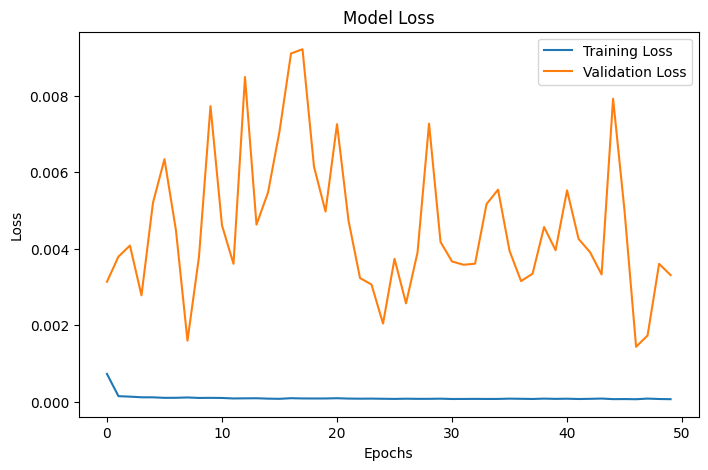

In [7]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012    
Test Loss: 0.0033116182312369347
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


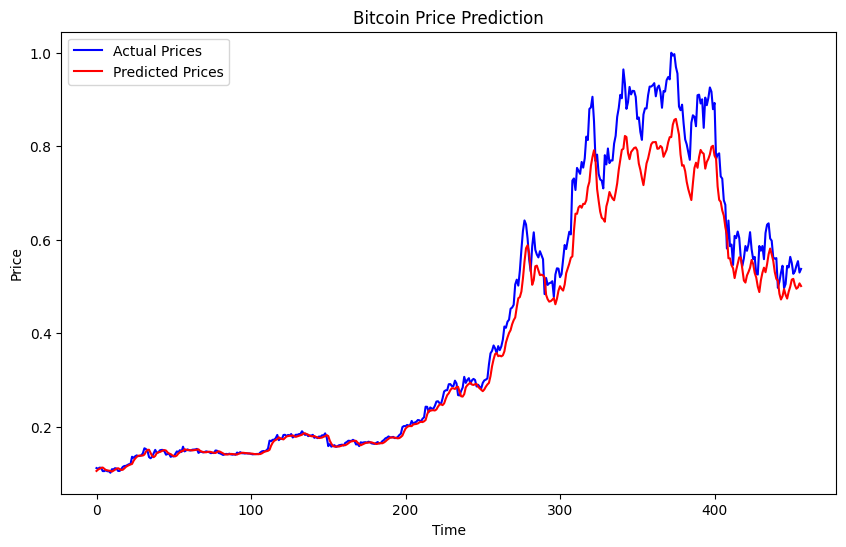

In [8]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predict future prices
y_pred = model.predict(X_test)

# Reverse scaling for predictions and actual values
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, label='Actual Prices', color='blue')
plt.plot(y_pred_unscaled, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:
model.save('bitcoin_price_lstm_updated.keras')


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100

# Print metrics
print(f"Metrics for Close Price Prediction:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Metrics for Close Price Prediction:
Mean Absolute Error (MAE): 0.035495
Mean Squared Error (MSE): 0.003312
Root Mean Squared Error (RMSE): 0.057547
R-squared (R²): 0.958826
Mean Absolute Percentage Error (MAPE): 5.88%


In [12]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----------------------------- ---------- 1.6/2.1 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 7.8 MB/s eta 0:00:00


In [13]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lstm_units = trial.suggest_categorical('lstm_units', [50, 100, 150, 200])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    epochs = trial.suggest_int('epochs', 20, 100, step=10)
    
    # Build the model
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0  # Suppress detailed training logs
    )
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])  # Use the minimum validation loss as the objective
    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # Minimize validation loss
study.optimize(objective, n_trials=50)  # Number of trials to run

# Print the best hyperparameters
print("Best Hyperparameters:")
print(study.best_params)

# Access the best trial
best_trial = study.best_trial


[I 2025-01-13 19:58:52,344] A new study created in memory with name: no-name-e56da760-b0e5-4bf0-80eb-66ae5cc7148a
C:\Users\Aleix\AppData\Local\Temp\ipykernel_4008\3479724878.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-01-13 19:59:47,423] Trial 0 finished with value: 0.0023075994104146957 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'batch_size': 32, 'lea

Best Hyperparameters:
{'lstm_units': 200, 'dropout_rate': 0.1, 'batch_size': 16, 'learning_rate': 0.002682009802297416, 'epochs': 40}


In [14]:
# Train the model with the best hyperparameters
best_params = study.best_params

new_model = Sequential([
    LSTM(best_params['lstm_units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units'], return_sequences=False),
    Dropout(best_params['dropout_rate']),
    Dense(25),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=best_params['learning_rate'])
new_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = new_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    verbose=1
)

# Evaluate on test data
test_loss = new_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


Epoch 1/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 2/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 1.0328e-04 - val_loss: 0.0040
Epoch 3/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 9.0659e-05 - val_loss: 0.0030
Epoch 4/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 9.3973e-05 - val_loss: 0.0027
Epoch 5/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 6.6989e-05 - val_loss: 0.0013
Epoch 6/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 8.6246e-05 - val_loss: 9.4568e-04
Epoch 7/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 5.0283e-05 - val_loss: 0.0055
Epoch 8/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 6.5695e-05 - val_loss: 6.2567e-04
Epoch 9/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 7.1903e-05 - val_loss: 6.2711e-04
Epoch 10/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 6.2178e-05 - val_loss: 0.0015
Epoch 11/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 5.6733e-

In [15]:
new_model.save('bitcoin_price_lstm_updated_tuned1.keras')


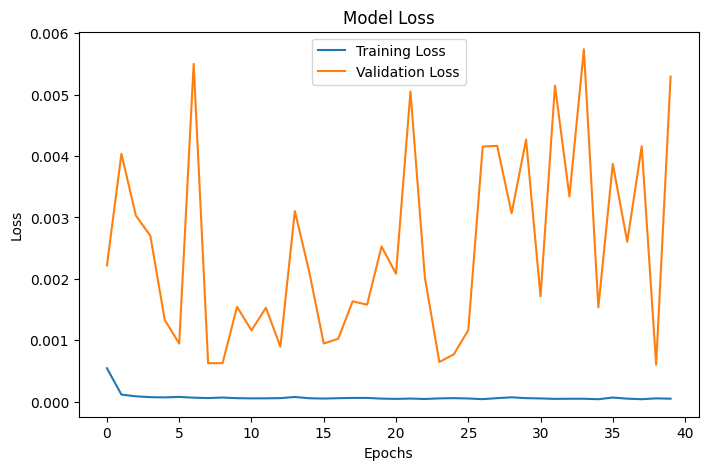

In [16]:

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0019
Test Loss: 0.005293022375553846
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


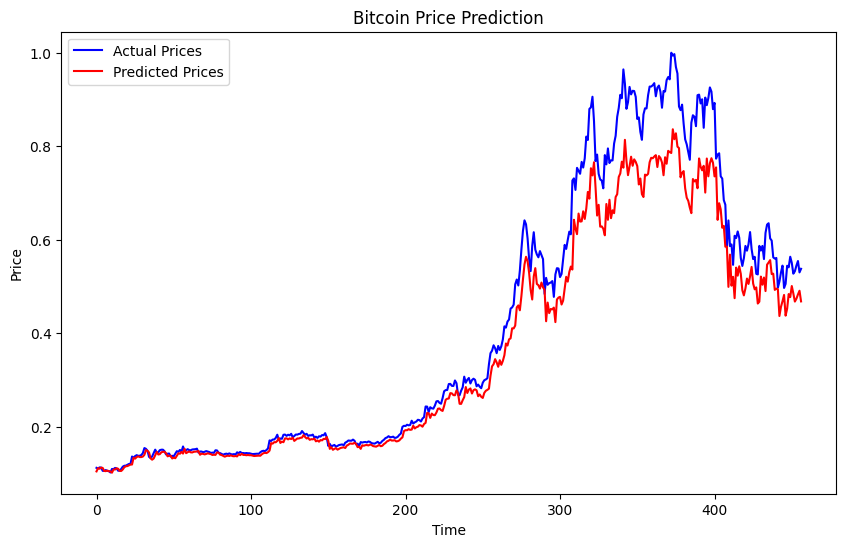

In [19]:
# Evaluate the model
test_loss = new_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predict future prices
y_pred = new_model.predict(X_test)

# Reverse scaling for predictions and actual values
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, label='Actual Prices', color='blue')
plt.plot(y_pred_unscaled, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [20]:
# Calculate metrics
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100

# Print metrics
print(f"Metrics for Close Price Prediction:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Metrics for Close Price Prediction:
Mean Absolute Error (MAE): 0.048114
Mean Squared Error (MSE): 0.005293
Root Mean Squared Error (RMSE): 0.072753
R-squared (R²): 0.934191
Mean Absolute Percentage Error (MAPE): 8.52%
